In [ ]:
print('Connect to google drive')
from google.colab import drive
drive.mount('/gdrive')

Connect to google drive
Mounted at /gdrive


In [ ]:
print('Import necessary libraries')

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob
import pickle

import warnings
warnings.filterwarnings("ignore")

import random
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import gc
import tqdm

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn import neighbors
import joblib

import matplotlib.pyplot as plt

Import necessary libraries


In [ ]:
base_path='/gdrive/My Drive/Colab Notebooks/'
weights_path='/gdrive/My Drive/Colab Notebooks/weights/'

In [ ]:
def euclidean_distance(x_true,y_true, x_pred, y_pred):
    return np.mean(((x_true-x_pred)**2+(y_true-y_pred)**2)**0.5)    

In [ ]:
version='forPdata423_numBSSIDS'


In [ ]:
data=pd.read_csv('/gdrive/My Drive/Colab Notebooks/data423.csv.zip') #
data.shape

(14373, 316)

In [ ]:
data.head()

,rsid1,rsid2,rsid3,rsid4,rsid5,rsid6,rsid7,rsid8,rsid9,rsid10,rsid11,rsid12,rsid13,rsid14,rsid15,rsid16,rsid17,rsid18,rsid19,rsid20,rsid21,rsid22,rsid23,rsid24,rsid25,rsid26,rsid27,rsid28,rsid29,rsid30,rsid31,rsid32,rsid33,rsid34,rsid35,rsid36,rsid37,rsid38,rsid39,rsid40,...,rsid277,rsid278,rsid279,rsid280,rsid281,rsid282,rsid283,rsid284,rsid285,rsid286,rsid287,rsid288,rsid289,rsid290,rsid291,rsid292,rsid293,rsid294,rsid295,rsid296,rsid297,rsid298,rsid299,rsid300,rsid301,rsid302,rsid303,rsid304,rsid305,rsid306,rsid307,rsid308,rsid309,rsid310,rsid311,rsid312,x,y,timestamp,path
0,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934464983,record_2021_10_11_07_41_02
1,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934467125,record_2021_10_11_07_41_02
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934469251,record_2021_10_11_07_41_02
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934471370,record_2021_10_11_07_41_02
4,-78,-999,-999,-95,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-50,-51,-51,-43,-49,-47,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-87,-87,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,40.85,25.74,1633934473508,record_2021_10_11_07_41_02


In [ ]:
rssidsnums=[int(x[4:]) for x in data.columns if 'rsid' in x]
print(len(rssidsnums))

312


In [ ]:
min(rssidsnums),max(rssidsnums)

(1, 312)

In [ ]:
print(len(rssidsnums)*0.5),print(len(rssidsnums)*0.75)

156.0
234.0


(None, None)

In [ ]:
np.random.seed(2022)
selected_rsidnums=np.sort(np.random.choice(np.arange(min(rssidsnums),max(rssidsnums)), size=234,replace=False))
selected_rsids=['rsid'+str(x) for x in selected_rsidnums]
TRAIN_FEATS=selected_rsids[:]
print(len(selected_rsids))

234


In [ ]:
selected_columns=selected_rsids[:]+ ['x', 'y', 'path', 'timestamp']
print(len(selected_columns))

238


In [ ]:
# data.head()

In [ ]:
TRAIN_FEATS=selected_rsids[:]
# TRAIN_FEATS=[x for x in data.columns if x not in ['x', 'y', 'path', 'timestamp']]
len(TRAIN_FEATS)

234

In [ ]:
# dataA=data.copy()

In [ ]:
# data=dataA.loc[data.setNum==1,:]
# data.shape

In [ ]:
unpaths=data.path.unique()

In [ ]:
print('we have ',len(unpaths),' unique paths')

we have  423  unique paths


### CV TRAIN

In [ ]:
# CROSS VALIDATION

name='KNeighbors'+version
scores=[]
for rs in range(100):
    np.random.seed(2022+rs)
    selected_rsidnums=np.sort(np.random.choice(np.arange(min(rssidsnums),max(rssidsnums)), size=234,replace=False))
    selected_rsids=['rsid'+str(x) for x in selected_rsidnums]
    TRAIN_FEATS=selected_rsids[:]
    # print(len(selected_rsids))


    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)



    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values


        knn = neighbors.KNeighborsRegressor(45, weights='distance')
        val_predsXY = knn.fit(X_train, y_trainXY).predict(X_val)

        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print(np.mean(scores))
    print('---------------------')


In [ ]:
print(np.mean(scores))
print(np.std(scores))

2.4619287079423624
0.01840774008262287


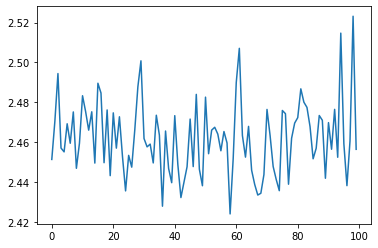

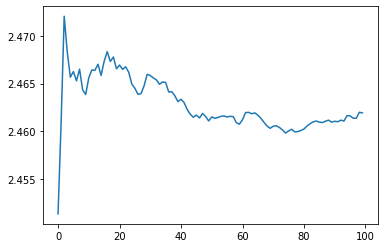

In [ ]:
plt.plot(scores)
plt.show()

plt.plot(np.cumsum(scores)/np.arange(1,len(scores)+1))
plt.show()

In [ ]:
# CROSS VALIDATION

name='KNeighbors'+version
scores=[]
for rs in range(100):
    np.random.seed(2022+rs)
    selected_rsidnums=np.sort(np.random.choice(np.arange(min(rssidsnums),max(rssidsnums)), size=156,replace=False))
    selected_rsids=['rsid'+str(x) for x in selected_rsidnums]
    TRAIN_FEATS=selected_rsids[:]
    # print(len(selected_rsids))


    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)



    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values


        knn = neighbors.KNeighborsRegressor(45, weights='distance')
        val_predsXY = knn.fit(X_train, y_trainXY).predict(X_val)

        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print(np.mean(scores))
    print('---------------------')


In [ ]:
print(np.mean(scores))
print(np.std(scores))

2.5851121703619295
0.04068768350640167


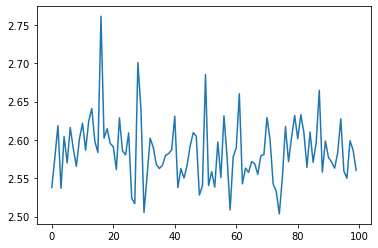

In [ ]:

plt.plot(scores)
plt.show()

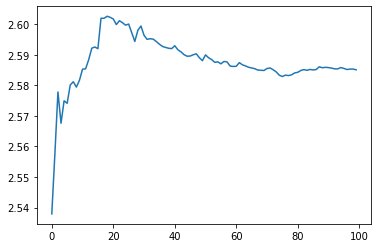

In [ ]:
plt.plot(np.cumsum(scores)/np.arange(1,len(scores)+1))
plt.show()


In [ ]:
# CROSS VALIDATION

name='KNeighbors'+version
scores=[]
for rs in range(400):
    np.random.seed(2022+rs)
    selected_rsidnums=np.sort(np.random.choice(np.arange(min(rssidsnums),max(rssidsnums)), size=78,replace=False))
    selected_rsids=['rsid'+str(x) for x in selected_rsidnums]
    TRAIN_FEATS=selected_rsids[:]
    # print(len(selected_rsids))


    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)



    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values


        knn = neighbors.KNeighborsRegressor(45, weights='distance')
        val_predsXY = knn.fit(X_train, y_trainXY).predict(X_val)

        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print(np.mean(scores))
    print('---------------------')


In [ ]:
print(np.mean(scores))
print(np.std(scores))

2.9427255480756447
0.10090685412709044


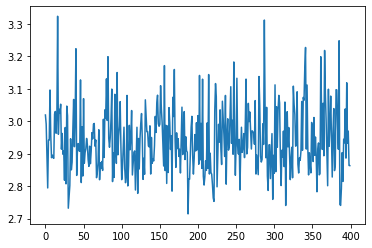

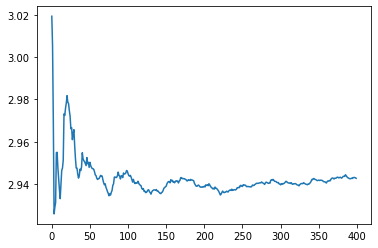

In [ ]:
plt.plot(scores)
plt.show()

plt.plot(np.cumsum(scores)/np.arange(1,len(scores)+1))
plt.show()

In [ ]:
# pd.DataFrame(all_predsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/KNeighbors_'+version+'.csv.gz', index=False, compression='gzip')
# pd.DataFrame(all_targetsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/all_targetsV_'+version+'.csv.gz', index=False, compression='gzip')

## EVALUATION - PLOTS

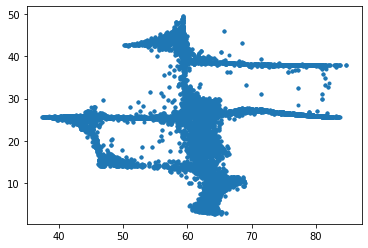

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_predsV[:,0],all_predsV[:,1],'.')
plt.show()

**5 FOLD CV PREDICTIONS OVER TARGET GRID**  
With blue dots are the true checkpoints  
Orange dots for predictions

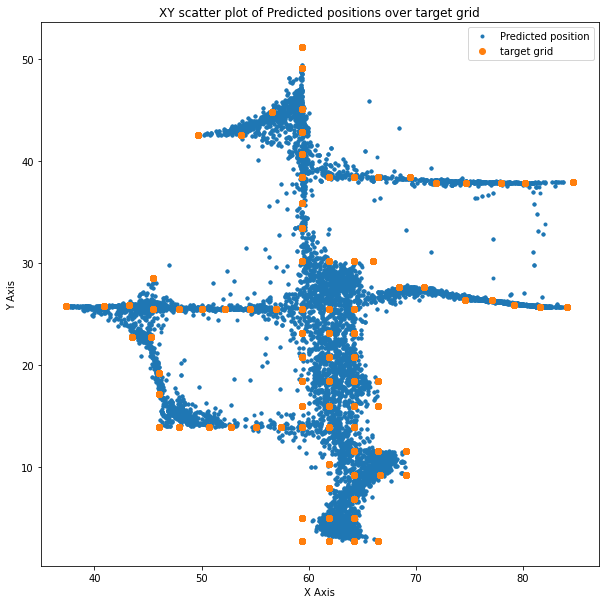

mean validation error, 5-fold 2.8632816265878205


In [ ]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

## Full train

In [ ]:


# name=version+'KNeighbors'



# train_paths=unpaths[:]

# train_paths=np.array(train_paths)

# X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

# y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values
# knn = neighbors.KNeighborsRegressor(45, weights='distance')
# knn_model=knn.fit(X_train, y_trainXY)
# train_predsXY = knn_model.predict(X_train)

# print('train error',euclidean_distance(train_predsXY[:,0], train_predsXY[:,1], y_trainXY[:,0], y_trainXY[:,1]))


In [ ]:
# print('Save Knn model fully trained')
# joblib.dump(knn_model,'/gdrive/My Drive/Colab Notebooks/weights/'+name+'_model')